Proyecto final de Simulacion digital grupo D1

Javier David Landazabal landazabal-2151482

Oscar Andrés Corzo Gómez-2160041

Jose Nelson Amaris Ortiz-2160028

## COMPORTAMIENTO DEL PRECIO DE PRODUCTOS AGRÍCOLAS.


cargamos a colaboratory el archivo.xlsx

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.metrics import mean_squared_error
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [0]:
# import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving dataSetSimulation.xlsx to dataSetSimulation (1).xlsx


cargamos los datos al notebook

In [69]:
data = pd.read_excel('dataSetSimulation.xlsx')
print(data.head(-1))

         fecha  precio Variacion
0   2018-06-01   38000         b
1   2018-06-02   37000         b
2   2018-06-03   37000         m
3   2018-06-04   40000         s
4   2018-06-05   45000         s
..         ...     ...       ...
638 2020-02-29   28000         s
639 2020-03-01   30000         s
640 2020-03-02   35000         s
641 2020-03-03   35000         m
642 2020-03-04   35000         m

[643 rows x 3 columns]


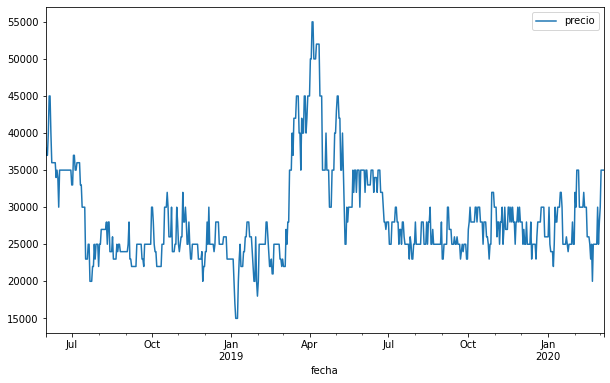

In [70]:
data.plot.line(x = 'fecha', 
             y = 'precio')

SERIES DE TIEMPO

Pasamos los datos a una Serie de Tiempo.

In [71]:
data['fecha'] = pd.to_datetime(data['fecha'])
data.set_index('fecha', inplace=True)
ts = data['precio']
ts

fecha
2018-06-01    38000
2018-06-02    37000
2018-06-03    37000
2018-06-04    40000
2018-06-05    45000
              ...  
2020-03-01    30000
2020-03-02    35000
2020-03-03    35000
2020-03-04    35000
2020-03-05    35000
Name: precio, Length: 644, dtype: int64

Ahora realizamos la prueba de estacionariedad

In [0]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

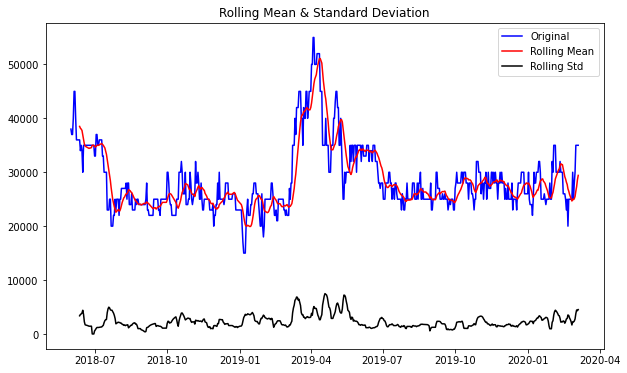

Results of Dickey-Fuller Test:
Test Statistic                  -3.951803
p-value                          0.001685
#Lags Used                       1.000000
Number of Observations Used    642.000000
Critical Value (1%)             -3.440577
Critical Value (5%)             -2.866052
Critical Value (10%)            -2.569173
dtype: float64


In [73]:
test_stationarity(ts)

Como lo muestra el testpodemos estar un 99% seguros de que nuestra serie de tiempo es estacionaria

Ahora podemos realizar predicciones sobre nuestra serie de tiempo, para esto aplicaremos el metodo de ARIMA.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


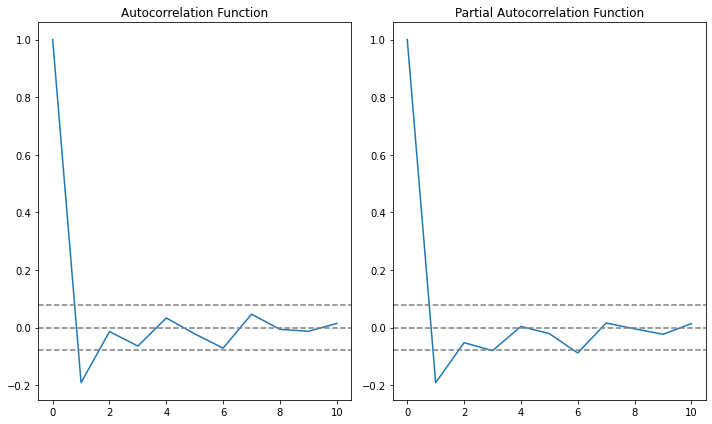

In [74]:
ts_log = np.log(ts)
tsf = ts_log - ts_log.shift()
tsf.dropna(inplace=True)
lag_acf = acf(tsf, nlags=10)
lag_pacf = pacf(tsf, nlags=10, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsf)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsf)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsf)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsf)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

Despues de realizar diferentes pruebas con los parametros p, d y q para obtener el mejor valor de RSS (suma del residual cuadrado) quedaron los siguientes:

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Plotting ARIMA model


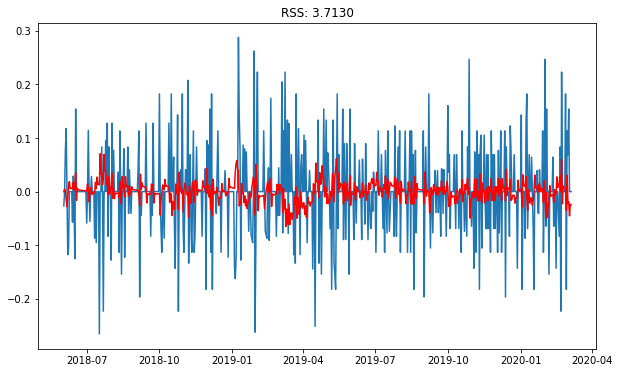

In [75]:
model = ARIMA(ts_log, order=(2,1,2))
resultados_ARIMA = model.fit(disp=-1)
plt.plot(tsf)
plt.plot(resultados_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((resultados_ARIMA.fittedvalues - tsf)**2))
print('Plotting ARIMA model')

In [76]:
# pasamos los resultados de predicción al formato de series de Pandas Dataframe
predict_ARIMA_a = pd.Series(resultados_ARIMA.fittedvalues, copy=True)
# calculamos los valores adjuntados realizando una operacion acumulativa a los datos, como una funcion de probabilidad acumulativa
predict_ARIMA_acumulada = predict_ARIMA_a.cumsum()
predict_ARIMA_acumulada

fecha
2018-06-02   -0.000279
2018-06-03    0.004469
2018-06-04    0.005312
2018-06-05   -0.009257
2018-06-06   -0.036948
                ...   
2020-03-01    0.113851
2020-03-02    0.094919
2020-03-03    0.049659
2020-03-04    0.025955
2020-03-05    0.001458
Length: 643, dtype: float64

In [0]:
predict_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predict_ARIMA_log = predict_ARIMA_log.add(predict_ARIMA_acumulada, fill_value=0)
predict_ARIMA = np.exp(predict_ARIMA_log)

Ahora los datos de predicción deben ser transformados, es decir, quitar la funcion logaritmica.

In [0]:
predict_ARIMA = np.exp(predict_ARIMA_log)

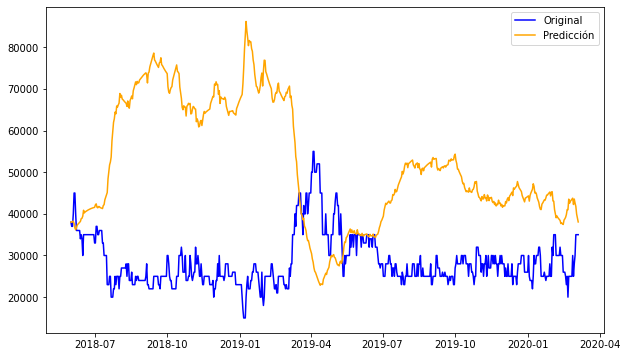

In [79]:
plt.plot(ts, color='blue', label='Original')
plt.plot(predict_ARIMA, color='orange', label='Predicción')
plt.legend(loc='best')
plt.show()

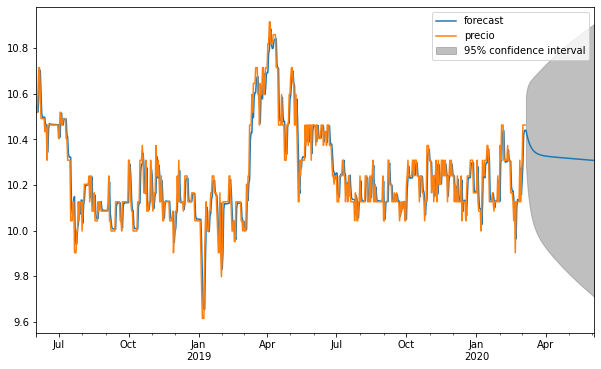

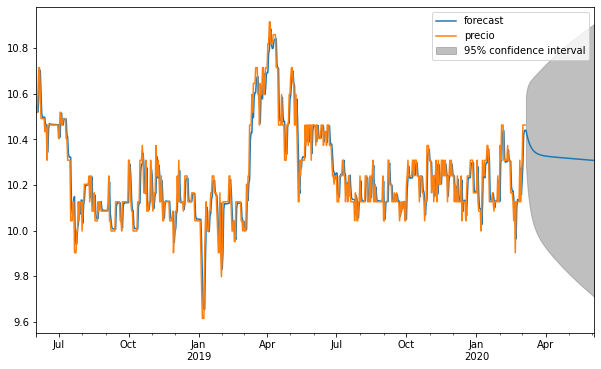

In [80]:
resultados_ARIMA.plot_predict(1,644+90) 

### MARKOV

hacemos conteo de la cantidad de veces que varian los precios

In [109]:
varTotal=data['Variacion'].size
print(data['Variacion'].value_counts())
mantuvo=(data[data.Variacion == 'm'].size)/3
bajo=(data[data.Variacion == 'b'].size)/3
subio=(data[data.Variacion == 's'].size)/3

m    342
b    154
s    148
Name: Variacion, dtype: int64


sacamos las diferentes probabilidades de los precios (bajan, suben o se mantienen).

In [110]:
M=mantuvo/varTotal
B=bajo/varTotal
S=subio/varTotal
print('Se mantuvo',(M)*100,'%')
print('Bajo',(B)*100,'%')
print('Subio',(S)*100,'%')

Se mantuvo 53.105590062111794 %
Bajo 23.91304347826087 %
Subio 22.981366459627328 %


Ahora sacamos las diferentes probalidades de cambio de estado respecto a un estados especifico

In [100]:
# aqui se desea saber la probabilidad de cambio respecto al dia anterior
bb=0;bm=0;bs=0;mb=0;mm=0;ms=0;sb=0;sm=0;ss=0
for i in range (varTotal-1):
  if (data.iloc[i,2]=='b'):
    if (data.iloc[(i+1),2]=='b'):
      bb=bb+1
    if (data.iloc[(i+1),2]=='m'):
      bm=bm+1
    if (data.iloc[(i+1),2]=='s'):
      bs=bs+1

  if (data.iloc[i,2]=='s'):
    if (data.iloc[(i+1),2]=='b'):
      sb=sb+1
    if (data.iloc[(i+1),2]=='m'):
      sm=sm+1
    if (data.iloc[(i+1),2]=='s'):
      ss=ss+1


  if (data.iloc[i,2]=='m'):
    if (data.iloc[(i+1),2]=='b'):
      mb=mb+1
    if (data.iloc[(i+1),2]=='m'):
      mm=mm+1
    if (data.iloc[(i+1),2]=='s'):
      ms=ms+1

proBB=bb/(bb+bm+bs)
proBM=bm/(bb+bm+bs)
proBS=bs/(bb+bm+bs)
print('Probabilidad de mañana bajar el precio si hoy bajo es de: ',proBB*100,'%')
print('Probabilidad de mañana mantener el precio si hoy bajo es de: ',proBM*100,'%')
print('Probabilidad de mañana subir el precio si hoy bajo es de: ',proBS*100,'%\n')
proSB=sb/(sb+sm+ss)
proSM=sm/(sb+sm+ss)
proSS=ss/(sb+sm+ss)
print('Probabilidad de mañana bajar el precio si hoy subio es de: ',proSB*100,'%')
print('Probabilidad de mañana mantener el precio si hoy subio es de: ',proSM*100,'%')
print('Probabilidad de mañana subir el precio si hoy subio es de: ',proSS*100,'%\n')
proMB=mb/(mb+mm+ms)
proMM=mm/(mb+mm+ms)
proMS=ms/(mb+mm+ms)
print('Probabilidad de mañana bajar el precio si hoy se mantuvo es de: ',proMB*100,'%')
print('Probabilidad de mañana mantener el precio si hoy se mantuvo es de: ',proMM*100,'%')
print('Probabilidad de mañana subir el precio si hoy se mantuvo es de: ',proMS*100,'%')

Probabilidad de mañana bajar el precio si hoy bajo es de:  17.532467532467532 %
Probabilidad de mañana mantener el precio si hoy bajo es de:  50.0 %
Probabilidad de mañana subir el precio si hoy bajo es de:  32.467532467532465 %

Probabilidad de mañana bajar el precio si hoy subio es de:  35.810810810810814 %
Probabilidad de mañana mantener el precio si hoy subio es de:  52.702702702702695 %
Probabilidad de mañana subir el precio si hoy subio es de:  11.486486486486488 %

Probabilidad de mañana bajar el precio si hoy se mantuvo es de:  21.407624633431084 %
Probabilidad de mañana mantener el precio si hoy se mantuvo es de:  54.83870967741935 %
Probabilidad de mañana subir el precio si hoy se mantuvo es de:  23.75366568914956 %


In [93]:
from io import BytesIO
from PIL import Image
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['mapa.jpg']))

Saving mapa.jpg to mapa.jpg


Grafo de estados y probabilidades

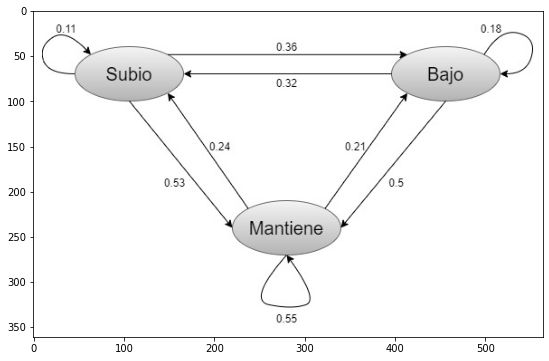

In [0]:
import matplotlib.pyplot as plt
plt.imshow(im)
plt.show()

Matriz de transicion

In [112]:
P = np.array([[proSS, proSM, proSB],
               [proMS, proMM, proMB],
               [proBS, proBM, proBB]])
P

array([[0.11486486, 0.52702703, 0.35810811],
       [0.23753666, 0.5483871 , 0.21407625],
       [0.32467532, 0.5       , 0.17532468]])

In [0]:
#p1 = np.array( [1, 0, 0] )
p1 = P
for i in range(1, 13):
    p_i = p1 @ P
    #print('p_{0:} = {1:}'.format(i, p_i))
    p1 = p_i

la matriz estacionaria es 

In [114]:
p1

array([[0.2300536 , 0.53195755, 0.23798885],
       [0.2300536 , 0.53195755, 0.23798885],
       [0.2300536 , 0.53195755, 0.23798885]])

En caso de que querramos hacer una prediccion del estado del precio para x dias, solo tenemos que mirar la matriz invariante de los datos obtenidos

In [116]:
print('Probabilidad de que mañana suba el precio si hoy bajó es de: ',P[2,0]*100,'%')
print('Probabilidad de que aqui en N dias suba el precio si hoy se mantuvo es de: ',p1[0,0]*100,'%')
print('Probabilidad de que aqui en N dias baje el precio si hoy se mantuvo es de: ',p1[0,2]*100,'%')
print('Probabilidad de que aqui en N dias se mantenga el precio si hoy se mantuvo es de: ',p1[0,1]*100,'%')

Probabilidad de que mañana suba el precio si hoy bajó es de:  32.467532467532465 %
Probabilidad de que aqui en N dias suba el precio si hoy se mantuvo es de:  23.00536004743098 %
Probabilidad de que aqui en N dias baje el precio si hoy se mantuvo es de:  23.798885331339108 %
Probabilidad de que aqui en N dias se mantenga el precio si hoy se mantuvo es de:  53.195754621229874 %
